In [66]:
import pandas as pd 
import numpy as np
import itertools
import re
import string
pd.set_option('display.max_colwidth', 100)
import nltk.corpus
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
#!pip install contractions
import contractions 
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix,precision_recall_fscore_support
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
#!pip install xgboost
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
reviews = pd.read_json(r'C:\Users\dfota\OneDrive\Έγγραφα\Thesis Project\Amazon-Game-Reviews-Analysis\Data\MergedDataset.json')

In [3]:
reviews.head()

,asin,overall,reviewTime,title,category,imageURLHighRes,reviews
0,B00000DMAN,5,"11 28, 1999",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This game is a lot of fun, with a creepy atmosphere that revolves around the disappearance of Ag..."
1,B00000DMAN,4,"03 5, 2003",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This was not the best mystery/adventure game I've ever played, and I'm not even a big fan of suc..."
2,B00000DMAN,4,"02 13, 2001",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This was a pretty good game, but not a great game. I'd probably rate this closer to 3 1/2 stars...."
3,B00000DMAN,4,"08 19, 2000",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,We stopped watching the series (lack of time) and so this was a nice way to keep the excitement...
4,B00000DMAN,5,"07 27, 2000",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"As a fan of Myst and Riven, I would not put this game in the same category. However, it does e..."


In [4]:
reviews['rating_class'] = reviews['overall'].apply(lambda x: 'bad' if x < 3 else'good')
reviews.head()

,asin,overall,reviewTime,title,category,imageURLHighRes,reviews,rating_class
0,B00000DMAN,5,"11 28, 1999",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This game is a lot of fun, with a creepy atmosphere that revolves around the disappearance of Ag...",good
1,B00000DMAN,4,"03 5, 2003",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This was not the best mystery/adventure game I've ever played, and I'm not even a big fan of suc...",good
2,B00000DMAN,4,"02 13, 2001",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This was a pretty good game, but not a great game. I'd probably rate this closer to 3 1/2 stars....",good
3,B00000DMAN,4,"08 19, 2000",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,We stopped watching the series (lack of time) and so this was a nice way to keep the excitement...,good
4,B00000DMAN,5,"07 27, 2000",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"As a fan of Myst and Riven, I would not put this game in the same category. However, it does e...",good


In [5]:
reviews['rating_class'].value_counts()

good    95521
bad     16061
Name: rating_class, dtype: int64

In [6]:
raw_tokens=len([w for t in (reviews["reviews"].apply(word_tokenize)) for w in t])
print('Number of raw tokens: {}'.format(raw_tokens))

Number of raw tokens: 21317836


In [7]:
def text_cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [8]:
def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

In [9]:
def replace_numbers(text):
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

In [10]:
stopword_list= stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [11]:
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words

In [12]:
def lemmatize_text(words):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in words]

In [13]:
def normalize_and_lemmatize(input):
    sample = text_cleaning(input)
    sample = expand_contractions(sample)
    words = nltk.word_tokenize(sample)
    words = remove_stopwords(words)    
    lemmas = lemmatize_text(words)
    return ' '.join(lemmas)

In [14]:
reviews['clean_text'] = reviews['reviews'].map(lambda text: normalize_and_lemmatize(text))

In [15]:
clean_tokens=len([w for t in (reviews["clean_text"].apply(word_tokenize)) for w in t])
print('Number of clean tokens: {}\n'.format(clean_tokens))
print('Percentage of removed tokens: {0:.2f}'.format(1-(clean_tokens/raw_tokens)))

Number of clean tokens: 9386880

Percentage of removed tokens: 0.56


In [16]:
def token (text):
    token = [w for w in nltk.word_tokenize(text)]
    return token

reviews['token'] = reviews['clean_text'].apply(token)

In [17]:
reviews.head()

,asin,overall,reviewTime,title,category,imageURLHighRes,reviews,rating_class,clean_text,token
0,B00000DMAN,5,"11 28, 1999",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This game is a lot of fun, with a creepy atmosphere that revolves around the disappearance of Ag...",good,game lot fun creepy atmosphere revolves around disappearance agent mulder scully heard complain ...,"[game, lot, fun, creepy, atmosphere, revolves, around, disappearance, agent, mulder, scully, hea..."
1,B00000DMAN,4,"03 5, 2003",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This was not the best mystery/adventure game I've ever played, and I'm not even a big fan of suc...",good,not best mysteryadventure game ever played not even big fan game begin serious xphile despite se...,"[not, best, mysteryadventure, game, ever, played, not, even, big, fan, game, begin, serious, xph..."
2,B00000DMAN,4,"02 13, 2001",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This was a pretty good game, but not a great game. I'd probably rate this closer to 3 1/2 stars....",good,pretty good game not great game id probably rate closer star agent craig wilmore scully mulder d...,"[pretty, good, game, not, great, game, id, probably, rate, closer, star, agent, craig, wilmore, ..."
3,B00000DMAN,4,"08 19, 2000",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,We stopped watching the series (lack of time) and so this was a nice way to keep the excitement...,good,stopped watching series lack time nice way keep excitement going game good perhaps little disori...,"[stopped, watching, series, lack, time, nice, way, keep, excitement, going, game, good, perhaps,..."
4,B00000DMAN,5,"07 27, 2000",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"As a fan of Myst and Riven, I would not put this game in the same category. However, it does e...",good,fan myst riven would not put game category however equally well type myst riven not main charact...,"[fan, myst, riven, would, not, put, game, category, however, equally, well, type, myst, riven, n..."


In [18]:
reviews['rating_class'] = reviews['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

In [19]:
X = reviews['clean_text']
y = reviews['rating_class']

In [20]:
#!pip install sklearn

# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [21]:
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(83686,)
Test Set Shape		:(27896,)


In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.ocean):
    """
    Create a confusion matrix plot for 'good' and 'bad' rating values 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [23]:
def disp_confusion_matrix(y_pred, model_name, vector = 'CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Bad','Good'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

In [24]:
# Create the word vector with CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,1), max_features=10000)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [25]:
print('Vocabulary length :', len(count_vect.get_feature_names()))

Vocabulary length : 10000


In [26]:
# Assign feature names of vector into a variable
vocab = count_vect.get_feature_names()

In [27]:
pd.DataFrame(count_vect_train, columns = vocab)

,aa,aaa,abandon,abandoned,ability,abit,able,aboard,abomination,abound,...,zillion,zip,zombie,zombrex,zone,zoning,zoo,zoom,zoomed,zooming
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83682,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83683,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
def modeling(Model, Xtrain = count_vect_train, Xtest = count_vect_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score)) 

In [29]:
clf = DummyClassifier(strategy = 'stratified', random_state =42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
    
# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(score))

f1 score: 0.7549607743649035


In [30]:
# Compute and print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.16      0.15      0.15      4059
           1       0.86      0.86      0.86     23837

    accuracy                           0.76     27896
   macro avg       0.51      0.51      0.51     27896
weighted avg       0.75      0.76      0.75     27896



In [31]:
# Call the modeling function for logistic regression with countvectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'sag',
                                     class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

f1 score: 0.8898335675873317


In [32]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.56      0.85      0.67      4059
           1       0.97      0.89      0.93     23837

    accuracy                           0.88     27896
   macro avg       0.76      0.87      0.80     27896
weighted avg       0.91      0.88      0.89     27896



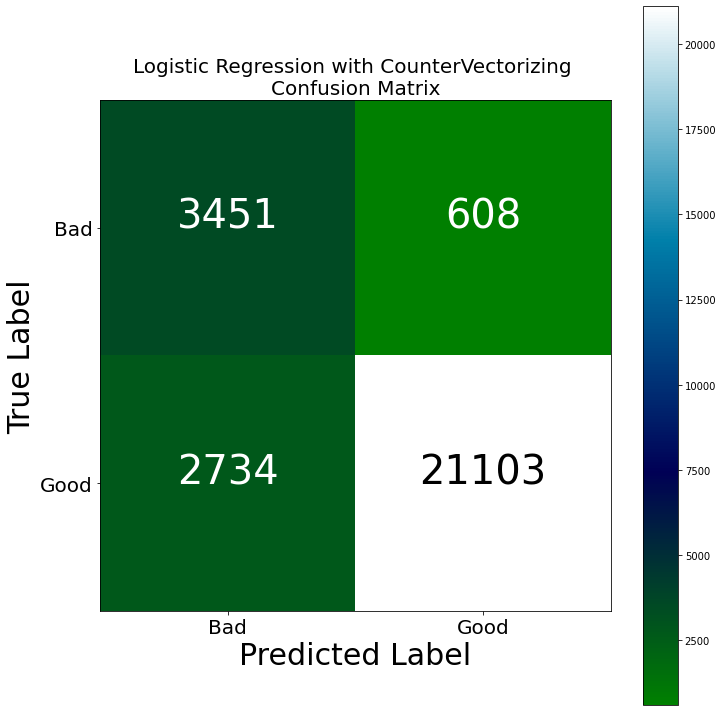

In [33]:
# Print confusion matrix for logistic regression with countvectorizer
disp_confusion_matrix(y_pred_cv_logreg, "Logistic Regression")

In [34]:
#model = LogisticRegression()
#parameters = {
#    'solver' : ['sag', 'saga']
#}

In [35]:
#grid_search = GridSearchCV(model, param_grid=parameters, cv=10,verbose = 1, 
#                          scoring='accuracy',error_score=0)

In [36]:
#grid_result = grid_search.fit(count_vect_train, y_train)

In [37]:
#grid_result.best_params_

In [38]:
#weights = {0:6.0, 1:1.0}
# Call the modeling function for logistic regression with countvectorizer and print f1 score
#modeling(LogisticRegression(multi_class = 'multinomial',max_iter = 4000, verbose = 1, solver = 'sag',
#                                     class_weight = weights, C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
#y_pred_cv_logreg = y_pred

In [39]:
# Compute and print the classification report
#print(classification_report(y_test, y_pred_cv_logreg))

In [40]:
# Print confusion matrix for logistic regression with countvectorizer
#disp_confusion_matrix(y_pred_cv_logreg, "Imbalanced Logistic Regression")

In [41]:
# Call the modeling function for random forest classifier with countvectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 100, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

f1 score: 0.8690770098083532


In [42]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       0.92      0.30      0.45      4059
           1       0.89      1.00      0.94     23837

    accuracy                           0.89     27896
   macro avg       0.90      0.65      0.69     27896
weighted avg       0.90      0.89      0.87     27896



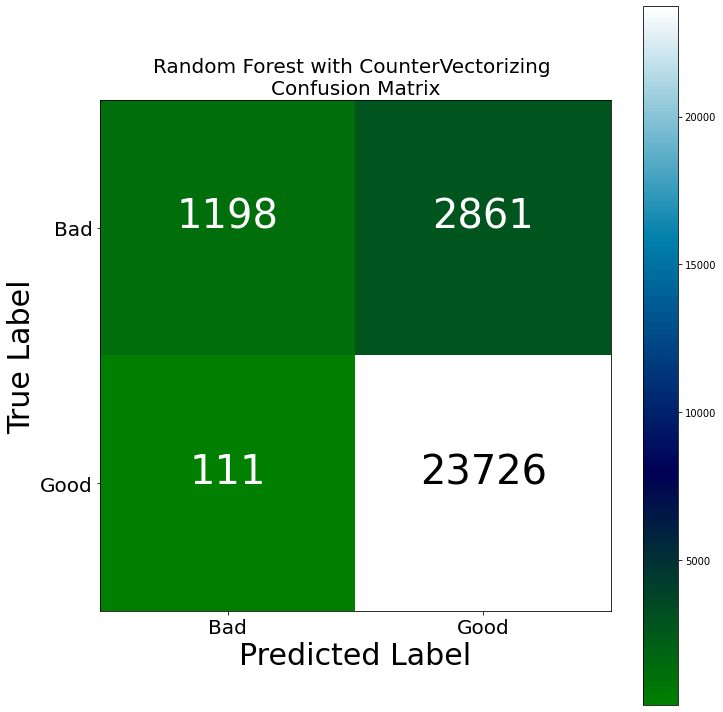

In [43]:
# Print confusion matrix for random forest classifier with countVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest")

In [44]:
#n_estimators = [10, 50, 100]

In [45]:
#param_grid = dict(n_estimators=n_estimators)

In [46]:
#dfrst = RandomForestClassifier(n_estimators=n_estimators)

In [47]:
#grid = GridSearchCV(estimator=dfrst, param_grid=param_grid)

In [48]:
#grid_results = grid.fit(count_vect_train, y_train)

In [49]:
#grid_results.best_params_

In [50]:
# Call the modeling function for random forest classifier with countvectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 50, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

f1 score: 0.8710455816121602


In [51]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       0.91      0.31      0.46      4059
           1       0.89      0.99      0.94     23837

    accuracy                           0.89     27896
   macro avg       0.90      0.65      0.70     27896
weighted avg       0.90      0.89      0.87     27896



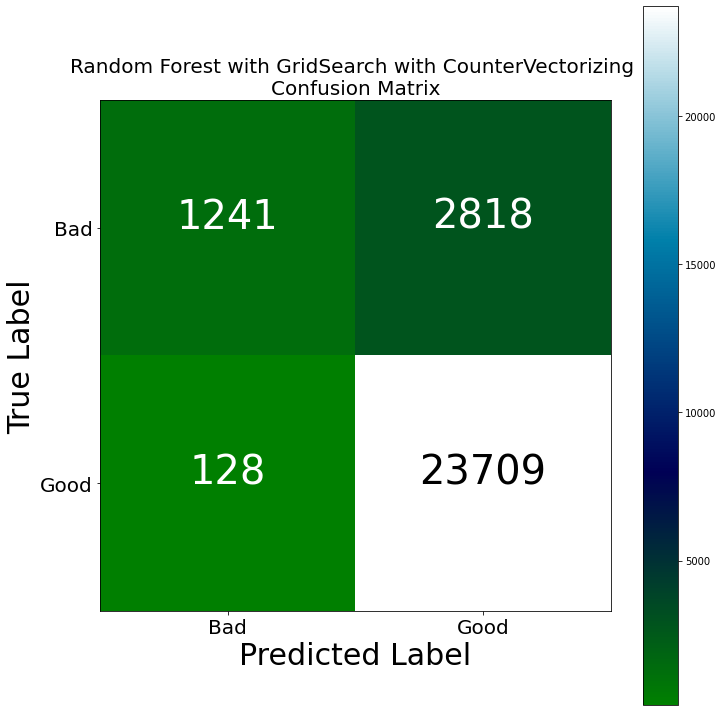

In [52]:
# Print confusion matrix for random forest classifier with countVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest with GridSearch")

In [53]:
# Call the modeling function for naive bayes with countvectorizer and print f1 score
modeling(MultinomialNB())

# Assign y_pred to a variable for further process
y_pred_cv_nb = y_pred

f1 score: 0.8939144404311608


In [54]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.61      0.70      0.65      4059
           1       0.95      0.92      0.94     23837

    accuracy                           0.89     27896
   macro avg       0.78      0.81      0.79     27896
weighted avg       0.90      0.89      0.89     27896



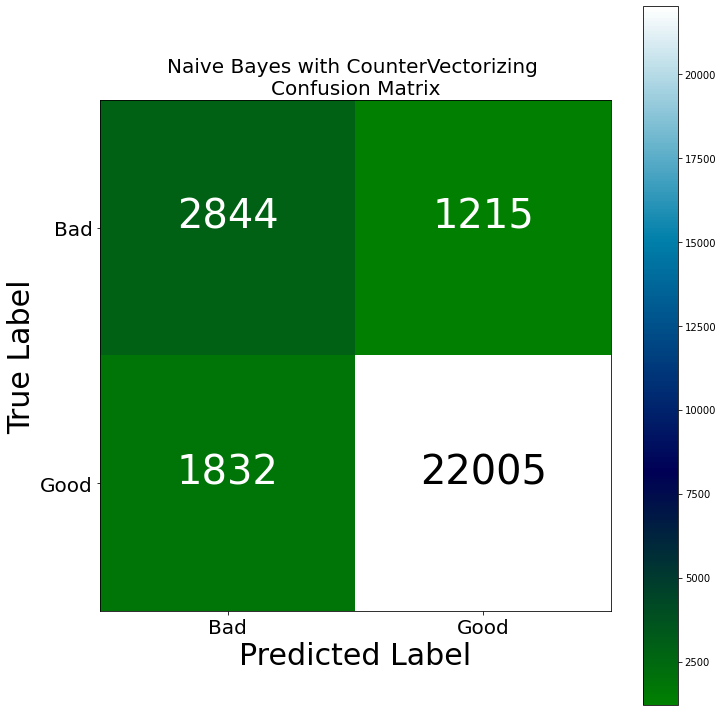

In [55]:
# Print confusion matrix for naive bayes with countVectorizer
disp_confusion_matrix(y_pred_cv_nb, "Naive Bayes")

In [56]:
# Call the modeling function for XGBoost with countvectorizer and print f1 score
modeling(XGBClassifier())

# Assign y_pred to a variable for further process
y_pred_cv_xgb = y_pred

[19:59:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 score: 0.9018376980364714


In [57]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.80      0.51      0.62      4059
           1       0.92      0.98      0.95     23837

    accuracy                           0.91     27896
   macro avg       0.86      0.75      0.79     27896
weighted avg       0.90      0.91      0.90     27896



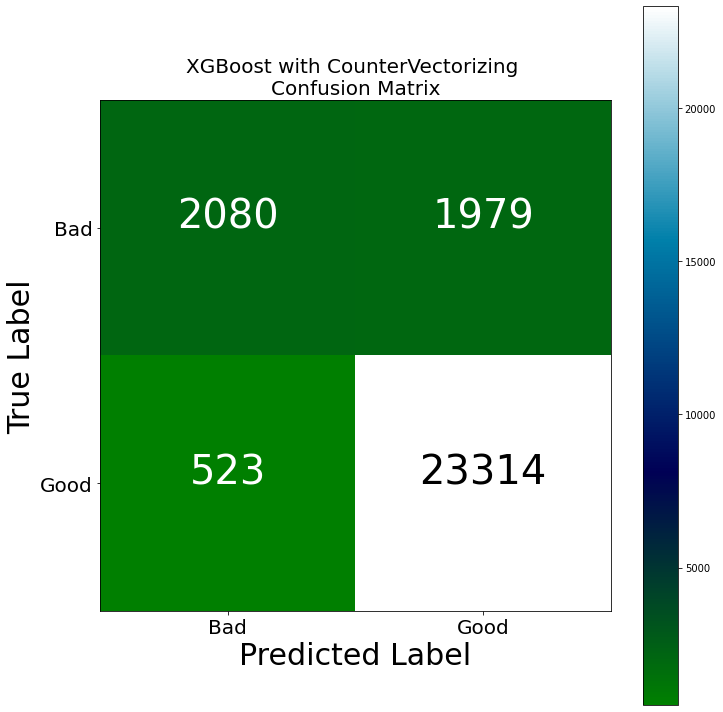

In [58]:
# Print confusion matrix for gradient boosting with countVectorizer
disp_confusion_matrix(y_pred_cv_xgb, "XGBoost")

In [59]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

In [60]:
# Function for adding explanatory columns and organizing all dataframe
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df['class']=['bad', 'good', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [61]:
#For loop for using "comparison functions" 

def comparison_table(y_preds, labels):
    
    # empty list for collecting dataframes
    frames_tv = [] 
    
    # list for y_preds
    y_preds_tv = y_preds
    
    # list for labels
    labels_tv = labels  
    
    vector_tv = 'CountVect'
    
    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = comparison_matrix(y_test, y_pred, label, vector_tv)
        frames_tv.append(df)

    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

In [62]:
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')
    
    for i,v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend()
    
    return plt.show()

In [67]:
comparison_table(y_preds = [y_pred_cv_logreg, y_pred_cv_rf, y_pred_cv_nb, y_pred_cv_xgb], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost'])

In [68]:
df_tv2

precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.880198 bad       0.557963  0.850209  0.673760   
                                  good      0.971996  0.885304  0.926627   
                                  average   0.911752  0.880198  0.889834   
           Random Forest 0.894393 bad       0.906501  0.305740  0.457259   
                                  good      0.893769  0.994630  0.941506   
                                  average   0.895621  0.894393  0.871046   
           Naive Bayes   0.890773 bad       0.608212  0.700665  0.651173   
                                  good      0.947674  0.923145  0.935249   
                                  average   0.898281  0.890773  0.893914   
           XGBoost       0.910310 bad       0.799078  0.512441  0.624437   
                                  good      0.921757  0.978059  0.949074   
                                  average   0.903907  0.910310  0.901838   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.880198 bad       4059.0  
                                  good     23837.0  
                                  average  27896.0  
           Random Forest 0.894393 bad       4059.0  
                                  good     23837.0  
                                  average  27896.0  
           Naive Bayes   0.890773 bad       4059.0  
                                  good     23837.0  
                                  average  27896.0  
           XGBoost       0.910310 bad       4059.0  
                                  good     23837.0  
                                  average  27896.0

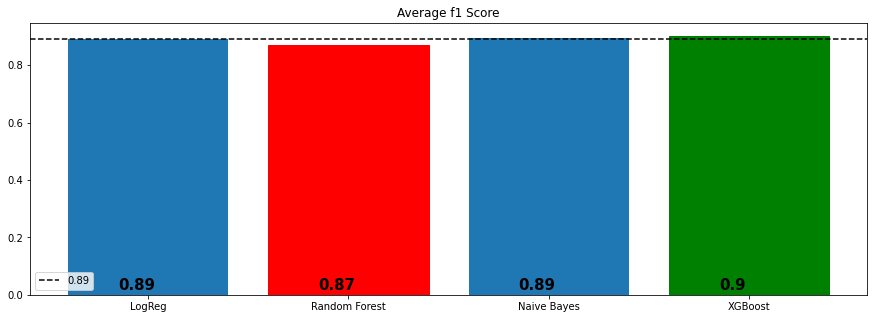

In [69]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average f1 Score")

In [70]:
# Create the word vector with TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1), max_features=10000)
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

In [71]:
# Call the modeling function for logistic regression with TF-IDF and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'sag', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), 
                            tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_logreg = y_pred

f1 score: 0.8864433356650955


In [72]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_logreg))

              precision    recall  f1-score   support

           0       0.54      0.88      0.67      4059
           1       0.98      0.87      0.92     23837

    accuracy                           0.88     27896
   macro avg       0.76      0.88      0.80     27896
weighted avg       0.91      0.88      0.89     27896



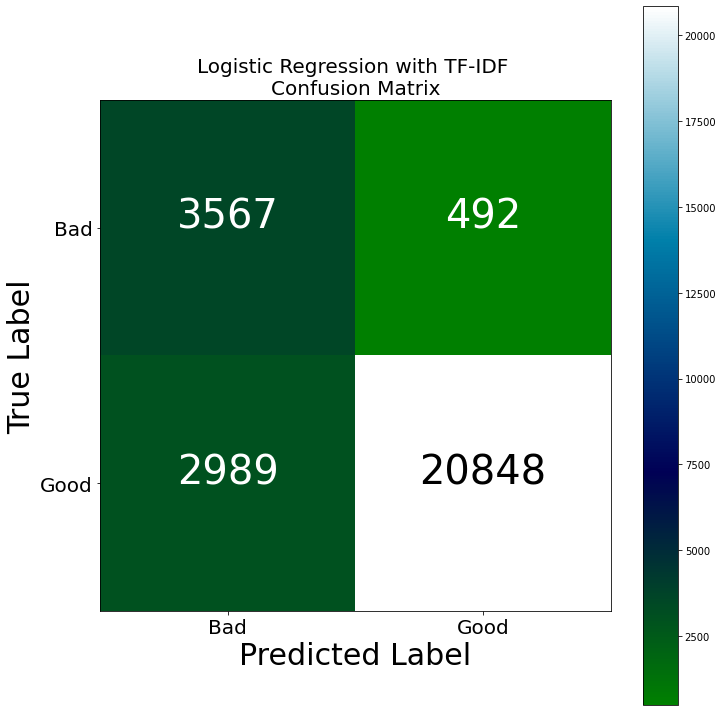

In [73]:
# Print confusion matrix for logistic regression with TF-IDF
disp_confusion_matrix(y_pred_tfidf_logreg, "Logistic Regression", "TF-IDF")

In [74]:
# Call the modeling function for random forest classifier with TF-IDF and print f1 score
modeling(RandomForestClassifier(n_estimators = 100, random_state = 42), 
         tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_rf = y_pred

f1 score: 0.8696807024793944


In [75]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_rf))

              precision    recall  f1-score   support

           0       0.93      0.29      0.45      4059
           1       0.89      1.00      0.94     23837

    accuracy                           0.89     27896
   macro avg       0.91      0.65      0.69     27896
weighted avg       0.90      0.89      0.87     27896



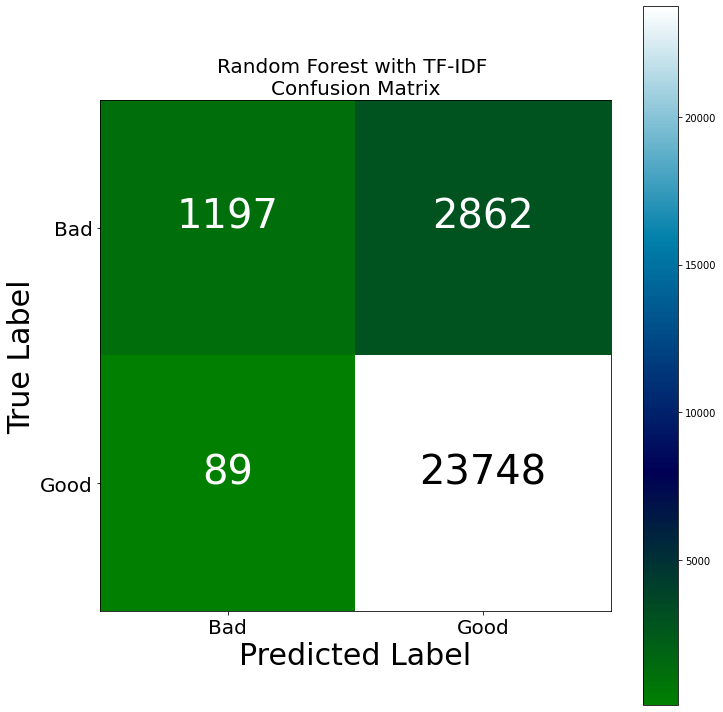

In [76]:
# Print confusion matrix for random forest classifier with TF-IDF
disp_confusion_matrix(y_pred_tfidf_rf, "Random Forest", "TF-IDF")

In [ ]:
#n_estimators = [10, 25, 50]

In [ ]:
#param_grid = dict(n_estimators=n_estimators)

In [ ]:
#dfrst = RandomForestClassifier(n_estimators=n_estimators)

In [ ]:
#grid = GridSearchCV(estimator=dfrst, param_grid=param_grid)

In [ ]:
#grid_results = grid.fit(tfidf_vect_train, y_train)

In [ ]:
#grid_results.best_params_

In [ ]:
#n_estimators = [50, 100, 200]

In [ ]:
#param_grid = dict(n_estimators=n_estimators)

In [ ]:
#dfrst = RandomForestClassifier(n_estimators=n_estimators)

In [ ]:
#grid = GridSearchCV(estimator=dfrst, param_grid=param_grid)

In [ ]:
#grid_results = grid.fit(tfidf_vect_train, y_train)

In [ ]:
#grid_results.best_params_

In [77]:
# Call the modeling function for naive bayes with TF-IDF and print f1 score
modeling(MultinomialNB(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_nb = y_pred

f1 score: 0.847955720087893


In [78]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_nb))

              precision    recall  f1-score   support

           0       0.91      0.21      0.34      4059
           1       0.88      1.00      0.93     23837

    accuracy                           0.88     27896
   macro avg       0.89      0.60      0.64     27896
weighted avg       0.88      0.88      0.85     27896



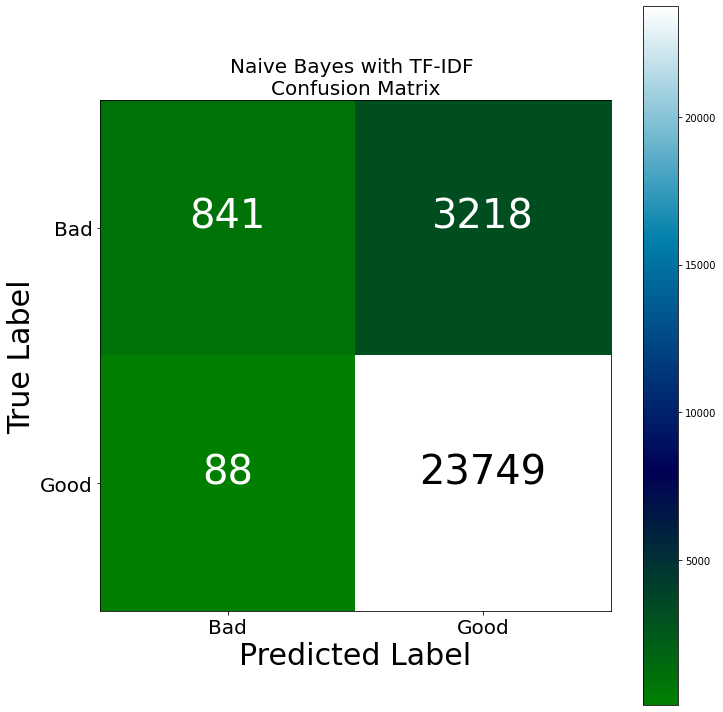

In [79]:
# Print confusion matrix for naive bayes with TF-IDF
disp_confusion_matrix(y_pred_tfidf_nb, "Naive Bayes", "TF-IDF")

In [80]:
# Call the modeling function for XGBoost with TF-IDF and print f1 score
modeling(XGBClassifier(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_xgb = y_pred

[20:35:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 score: 0.9046397390533396


In [81]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_xgb))

              precision    recall  f1-score   support

           0       0.81      0.52      0.64      4059
           1       0.92      0.98      0.95     23837

    accuracy                           0.91     27896
   macro avg       0.87      0.75      0.79     27896
weighted avg       0.91      0.91      0.90     27896



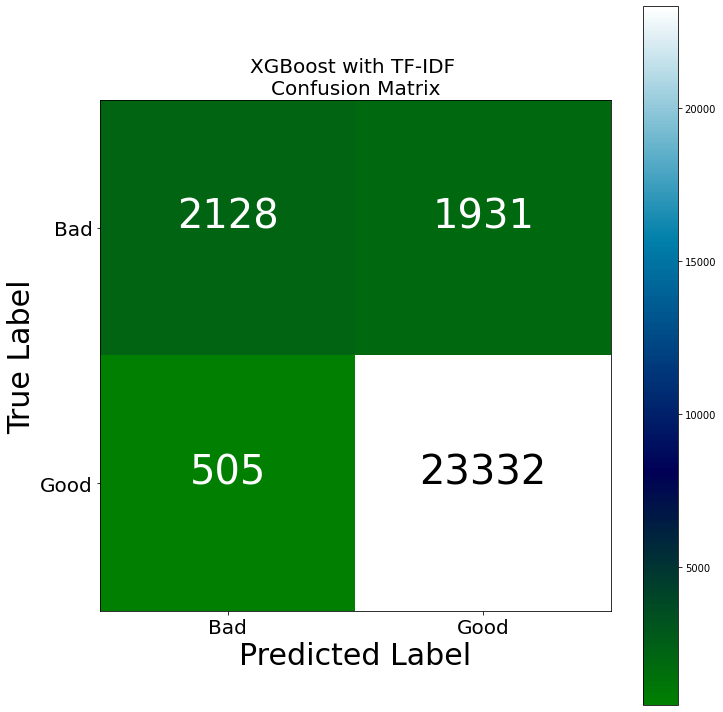

In [82]:
# Print confusion matrix for XGBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_xgb, "XGBoost", "TF-IDF")

In [83]:
comparison_table(y_preds = [y_pred_tfidf_logreg, y_pred_tfidf_rf, y_pred_tfidf_nb, y_pred_tfidf_xgb], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost'])

In [84]:
# Print the comparision matrix
print('\nComparision Matrix of Models with TF-IDF Vectorizer\n')
df_tv2


Comparision Matrix of Models with TF-IDF Vectorizer



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.875215 bad       0.544082  0.878788  0.672068   
                                  good      0.976945  0.874607  0.922948   
                                  average   0.913961  0.875215  0.886443   
           Random Forest 0.894214 bad       0.930793  0.294900  0.447895   
                                  good      0.892446  0.996266  0.941503   
                                  average   0.898026  0.894214  0.869681   
           Naive Bayes   0.881488 bad       0.905274  0.207194  0.337209   
                                  good      0.880669  0.996308  0.934926   
                                  average   0.884249  0.881488  0.847956   
           XGBoost       0.912676 bad       0.808204  0.524267  0.635983   
                                  good      0.923564  0.978814  0.950387   
                                  average   0.906779  0.912676  0.904640   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.875215 bad       4059.0  
                                  good     23837.0  
                                  average  27896.0  
           Random Forest 0.894214 bad       4059.0  
                                  good     23837.0  
                                  average  27896.0  
           Naive Bayes   0.881488 bad       4059.0  
                                  good     23837.0  
                                  average  27896.0  
           XGBoost       0.912676 bad       4059.0  
                                  good     23837.0  
                                  average  27896.0

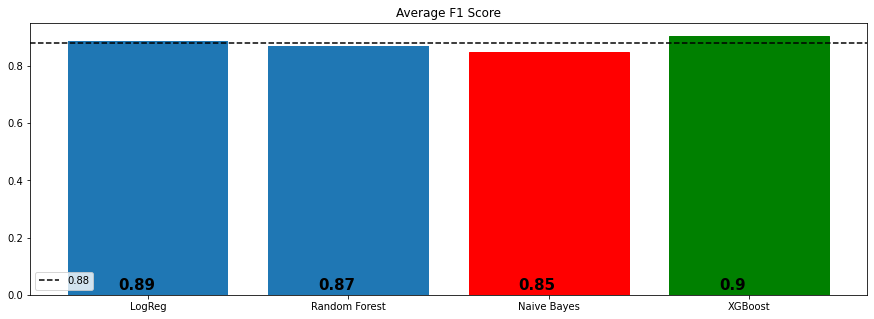

In [85]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")